In [21]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn.plotting as nil
import glob
from lito_radiomics.lito_radiomics.lito_features import shape2D
import os
import cupy as cp
from cupyx.scipy import ndimage
from cupy.linalg import eigh, svd
import cvxpy as cvxp
import math
import radiomics
from radiomics import featureextractor
from math import isclose
from concurrent.futures import ThreadPoolExecutor
import SimpleITK as sitk
from scipy import spatial
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
from nibabel.affines import apply_affine
import random
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt

In [22]:
cases_thresh = {
    'thresh_1' : 0.1, 
    'thresh_2' : 0.1,
    'thresh_4' : 0.1,
    'thresh_5' : 0.2,
    'thresh_6' : 0.2,
    'thresh_7' : 0.1,
    'thresh_8' : 0.1,
    'thresh_9' : 0.1,
    'thresh_10' : 0.1,
    'thresh_12' : 0.1,
    'thresh_13' : 0.2,
    'thresh_14' : 0.3,
    'thresh_15': 0.1,
    'thresh_16': 0.1,
    'thresh_17': 0.22,
    'thresh_18': 0.1,
    'thresh_19': 0.1,
    'thresh_20': 0.1,
    'thresh_21': 0.2,
    'thresh_22': 0.2,
    'thresh_23': 0.2,
    'thresh_24': 0.2,
    'thresh_25': 0.2,
    'thresh_26': 0.2,
    'thresh_27': 0.1,
    'thresh_28': 0.2,
    'thresh_29': 0.1,
    'thresh_30': 0.1,
    'thresh_31': 0.1,
    'thresh_32': 0.1,
    'thresh_33': 0.1,
    'thresh_34': 0.2,
    'thresh_35': 0.2,
    'thresh_36': 0.2,
    'thresh_37': 0.2,
    'thresh_38': 0.2,
    'thresh_39': 0.15,                       
    'thresh_40': 0.1,
    'thresh_41': 0.2,
    'thresh_42': 0.3,
    'thresh_43': 0.2,
    'thresh_44': 0.2,
    'thresh_45': 0.2,
    'thresh_46': 0.2,
    'thresh_47': 0.2,
    'thresh_48': 0.2,
    'thresh_49': 0.25,
    'thresh_50': 0.2,
    'thresh_51': 0.15,
    'thresh_52': 0.2,
    'thresh_53': 0.2,
    'thresh_54': 0.2,
    'thresh_55': 0.2,
    'thresh_56': 0.2,
    'thresh_57': 0.2,
    'thresh_58': 0.2,
    'thresh_59': 0.2,
    'thresh_60': 0.2,
    'thresh_61': 0.2,
    'thresh_62': 0.2,
    'thresh_63': 0.2,
    'thresh_64': 0.2,
    'thresh_65': 0.2,
    'thresh_66': 0.2,
    'thresh_67': 0.2,
    'thresh_68': 0.2,
    'thresh_69': 0.2,
    'thresh_70': 0.15,
    'thresh_04': 0.1,
    'thresh_05': 0.2,
    'thresh_06': 0.2,
    'thresh_07': 0.1,
    'thresh_08': 0.1,
    'thresh_09': 0.1,
    'thresh_10': 0.1,
    'thresh_12': 0.1,
    'thresh_13': 0.2,
    'thresh_14': 0.3,
    'thresh_15': 0.1,
    'thresh_16': 0.1,
    'thresh_17': 0.22,
    'thresh_18': 0.1,
    'thresh_19': 0.1,
    'thresh_20': 0.1,
    'thresh_21': 0.2,
    'thresh_22': 0.2,
    'thresh_23': 0.2,
    'thresh_24': 0.2,
    'thresh_25': 0.2,
    'thresh_26': 0.2,
    'thresh_27': 0.1,
    'thresh_28': 0.2,
    'thresh_29': 0.1,
    'thresh_30': 0.1,
    'thresh_31': 0.1,
    'thresh_32': 0.1,
    'thresh_33': 0.1,
    'thresh_34': 0.2,
    'thresh_35': 0.2,
    'thresh_36': 0.2,
    'thresh_37': 0.2,
    'thresh_38': 0.2,
    'thresh_39': 0.15, 
    'thresh_71': 0.2,
    'thresh_72': 0.1,
    'thresh_73': 0.2,
    'thresh_74' : 0.2,
    'thresh_75' : 0.15,
    'thresh_76' : 0.15,
    'thresh_77' : 0.2,
    'thresh_78' : 0.2,
    'thresh_79' : 0.2,
    'thresh_80' : 0.4,
    'thresh_81' : 0.1,
    'thresh_82' : 0.1,
    'thresh_83' : 0.1,
    'thresh_84' : 0.2,
    'thresh_85' : 0.2,
    'thresh_86' : 0.2,
    'thresh_87' : 0.2,
    'thresh_88' : 0.4,
    'thresh_89' : 0.2,
    'thresh_90' : 0.2,
    'thresh_91' : 0.2,
    'thresh_92' : 0.2,
    'thresh_93' : 0.2,
    'thresh_94' : 0.15,
    'thresh_95' : 0.25,
    'thresh_96' : 0.2,
    'thresh_97' : 0.2,
    'thresh_98' : 0.2,
    'thresh_99' : 0.25,
    'thresh_100' : 0.2,
    'thresh_101' : 0.2,
    'thresh_102' : 0.2,
    'thresh_103' : 0.2,
    'thresh_104' : 0.2,
    'thresh_105' : 0.2}

In [23]:
def check_registration(im1, im2):
    ax, az=im1.header['qoffset_x'], im1.header['qoffset_z'] 
    bx, bz=im2.header['qoffset_x'], im2.header['qoffset_z']

    if math.isclose(az, bz, rel_tol=0.05) and math.isclose(ax, bx, rel_tol=0.05):
        return True
    else:
        return False
    
def rescale_to_255(array):
    """
    Rescale the values of a 2D NumPy array to the range [0, 255].
    
    Parameters:
        array (numpy.ndarray): Input 2D array.
        
    Returns:
        numpy.ndarray: Rescaled array with values in the range [0, 255].
    """
    min_val = np.min(array)
    max_val = np.max(array)

    # Ensure the array is not constant to avoid division by zero
    if min_val != max_val:
        scaled_array = 255 * (array - min_val) / (max_val - min_val)
    else:
        scaled_array = array

    return scaled_array.astype(np.uint8)

def fill_holes(mask):
    filled_mask = scipy.ndimage.binary_fill_holes(mask[0, :, :]).astype(float)
    return filled_mask

def ellipse_perimeter(a, b):
    """
    Compute the perimeter of an ellipse using Ramanujan's approximation formula.
    
    Parameters:
        a (float): Length of the semi-major axis.
        b (float): Length of the semi-minor axis.
    
    Returns:
        float: Perimeter of the ellipse.
    """
    h = ((a - b) / (a + b))**2
    perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return perimeter
    

In [124]:
def compute_metrics_ellipse(a, b, eigen_vect, mask_slice, center=None):
    
    angle1 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0])
    angle2 = np.arctan(eigen_vect[1][1]/eigen_vect[1][0]) + np.deg2rad(90)
    
    if center is None:
        center = ndimage.center_of_mass(cp.asarray(sitk.GetArrayFromImage(mask_slice)))
        
    xy1 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle1))
    xy2 = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(center[1].item(), center[0].item(), a, b, angle2))
    
    ell1 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle1)
    ell2 = ellipse(center[1].item(), center[0].item(), a, b, rotation=angle2)

    contours = find_contours(sitk.GetArrayFromImage(mask_slice), 0.5)
    contours = [np.flip(contours[k]) for k in range(len(contours))]

    ellipse_estimation = EllipseModel()
    try:
        if ellipse_estimation.estimate(xy1):
            residuals1 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
            
        if ellipse_estimation.estimate(xy2):
            residuals2 = np.mean(np.concatenate([ellipse_estimation.residuals(contours[k]) for k in range(len(contours))]))
    except TypeError:
        residuals1, residuals2 = None, None
        
    shape_slice = sitk.GetArrayFromImage(mask_slice).shape
    mask_ellipse1 = np.zeros(shape_slice)
    mask_ellipse1[[i for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell1[::-1][0], ell1[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    mask_ellipse2 = np.zeros(shape_slice)
    mask_ellipse2[[i for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])], [j for (i, j) in zip(ell2[::-1][0], ell2[::-1][1]) if (i<shape_slice[0] and j<shape_slice[1])]] = 1

    dice1=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse1.ravel())
    dice2=1-spatial.distance.dice(sitk.GetArrayFromImage(mask_slice).ravel(), mask_ellipse2.ravel())

    try:
        if dice1 >= dice2:
            return residuals1, dice1, xy1, mask_ellipse1, center
        else:
            return residuals2, dice2, xy2, mask_ellipse2, center
    except UnboundLocalError:
        return False, False, False, False, False
    
    
def standardize_roi(image, mask, desired_area):

    # Calculate the current area of the ROI
    current_area = cp.sum(mask)

    # Calculate the scaling factor
    scale_factor = cp.sqrt(desired_area / current_area)
    
    return ndimage.zoom(cp.array(image), scale_factor), ndimage.zoom(cp.array(mask), scale_factor, order=0)


def _extracted_from_features_extraction2D_4(arg0, cut, data_spacing):
    result = sitk.GetImageFromArray(arg0[int(cut), :, :])
    result.SetSpacing(
        (
            float(data_spacing[0]),
            float(data_spacing[1]),
            float(data_spacing[2]),
        )
    )
    result = sitk.JoinSeries(result)

    return result

def _extracted_from_features_extraction2D_11():
    result = featureextractor.RadiomicsFeatureExtractor(force2D=True)
    result.disableAllFeatures()
    result.enableFeaturesByName(
        shape2D=[
            "PerimeterSurfaceRatio",
            "Sphericity",
            "MajorAxisLength",
            "MinorAxisLength",
            "Perimeter",
        ]
    )

    return result


def features_extraction2D(a_im, a_ma, cut, filled=True):

    data_spacing = [1,1,1]
    sitk_img = _extracted_from_features_extraction2D_4(a_im, cut, data_spacing)
    sitk_mask = _extracted_from_features_extraction2D_4(a_ma, cut, data_spacing)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    if filled is True:
        sitk_mask = sitk.GetImageFromArray(fill_holes(sitk.GetArrayFromImage(sitk_mask)))
    resized_image, resized_mask = standardize_roi(sitk.GetArrayFromImage(sitk_img), sitk.GetArrayFromImage(sitk_mask), 1250)
    resized_image = sitk.GetImageFromArray(cp.asnumpy(resized_image))
    resized_mask = sitk.GetImageFromArray(cp.asnumpy(resized_mask))
    features_40_slice = _extracted_from_features_extraction2D_11()
    features_40_slice_resized = _extracted_from_features_extraction2D_11()
    
    return sitk_img, sitk_mask, resized_image, resized_mask, features_40_slice, features_40_slice_resized


def check_orientation(ct_image, ct_arr):
    """
    Check the NIfTI orientation, and flip to  'RPS' if needed.
    :param ct_image: NIfTI file
    :param ct_arr: array file
    :return: array after flipping
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    
    if x != 'R':
        ct_arr = np.rot90(ct_arr, axes=(0,2), k=1)
    if y != 'P':
        ct_arr = np.flip(ct_arr, axis=1)
    if z != 'S':
        ct_arr = np.flip(ct_arr, axis=2)
    
    return ct_arr


def remove_out_of_box_mask(mask, box):
    _, y, z = np.where(~box.mask)
    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max()
    
    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)


    mask[:, :y_min_iso, :] = mask[:, y_max_iso+1:, :] = mask[:, :, :z_min_iso] = mask[:, :, z_max_iso+1:] = 0
    
    return mask


def resegment_thresholding(image, mask, thresh=0.2):
    
    max = (image*mask).max()
    new_mask20= np.ma.masked_where((image*mask) > thresh*max, mask)

    return new_mask20.mask.astype(float)


def random_slice_selection(rotated_mask):
    
    min_mask = np.argwhere(rotated_mask==1)[:, 0].min()
    max_mask = np.argwhere(rotated_mask==1)[:, 0].max()
    x = random.randint(min_mask, max_mask+1)
    print(x)

    return x


def apply_thresh(a_im, a_ma, a_ma_bb, thresh):
    
    a_ma_threshed = resegment_thresholding(np.array(a_im.dataobj), np.array(a_ma.dataobj), thresh=thresh)
    original_new_mask = nib.Nifti1Image(ndimage.binary_fill_holes(cp.array(a_ma_threshed)).astype(np.uint8), affine=a_ma.affine)

    final_image = cp.float32(a_im.dataobj)
    final_mask = cp.float32(original_new_mask.dataobj.get())
    final_mask_bb = cp.float32(a_ma_bb)
    final_mask = remove_out_of_box_mask(final_mask, np.ma.masked_equal(final_mask_bb, 0))

    return final_image, final_mask, final_mask_bb


def plot_1slice(im, ma, bb, center_ell, slice_nb, ell, dice, dice_resized):
    
    plt.close('all')
    inside_bb = bb * im
    to_display = np.ma.masked_equal(inside_bb, 0)

    x, y, z = np.where(~to_display.mask)

    y_min = y.min()
    y_max = y.max()
    z_min = z.min()
    z_max = z.max() 

    y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
    y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
    z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
    z_max_iso = int(z_max - (z_max-z_min)/2 + 25)

    y_mask, x_mask = np.where(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
    x_min_mask = x_mask.min()
    x_max_mask = x_mask.max()
    y_min_mask = y_mask.min()
    y_max_mask = y_mask.max()
    
    center = ndimage.center_of_mass(cp.asarray(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
    translated_ell = ell - (np.array([center_ell[1].item(), center_ell[0].item()]) - np.array([center[1].item(), center[0].item()]))
    center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
    plt.imshow(im[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey')
    plt.imshow(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(ma[slice_nb, y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
    plt.plot(translated_ell[:, 0], translated_ell[:, 1])
    #plt.scatter(center[1].get(), center[0].get())
    #plt.scatter(center_ma[0], center_ma[1])
    plt.title(f'{str(dice)[:5]}')# {str(dice_resized)[:5]}')

    plt.show()
    
    
def plot_slices(slices_im, slices_ma, slices_bb, center_ells, slices_nbs, ells, dices, dices_resized, n, mins, maxs):

    n_columns = 8
    n_rows = n // n_columns

    if n % n_columns != 0:
        n_rows += 1
    plt.close('all')
    _, axs = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(10, 5))
    axs = axs.flatten()
    for i in range(n):
        inside_bb = slices_bb[i] * slices_im[i]
        to_display = np.ma.masked_equal(inside_bb, 0)

        x, y, z = np.where(~to_display.mask)
        y_min = y.min()
        y_max = y.max()
        z_min = z.min()
        z_max = z.max() 

        y_min_iso = int(y_max - (y_max-y_min)/2 - 25)
        y_max_iso = int(y_max - (y_max-y_min)/2 + 25)
        z_min_iso = int(z_max - (z_max-z_min)/2 - 25)
        z_max_iso = int(z_max - (z_max-z_min)/2 + 25)
        
        y_mask, x_mask = np.where(slices_ma[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]==1)
        x_min_mask = x_mask.min()
        x_max_mask = x_mask.max()
        y_min_mask = y_mask.min()
        y_max_mask = y_mask.max()
        
        #center_ma = [x_min_mask + (x_max_mask-x_min_mask)/2, y_min_mask + (y_max_mask-y_min_mask)/2]
        center = ndimage.center_of_mass(cp.asarray(slices_ma[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]))
        translated_ell = ells[i] - (np.array([center_ells[i][1].item(), center_ells[i][0].item()]) - np.array([center[1].item(), center[0].item()]))
        
        axs[i].imshow(slices_im[i][slices_nbs[i], y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], interpolation='none', cmap='grey', vmin=mins[i], vmax=maxs[i])
        axs[i].imshow(slices_ma[i][slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1], alpha=0.25*(slices_ma[i][slices_nbs[i],y_min_iso:y_max_iso+1, z_min_iso:z_max_iso+1]>0))
        axs[i].plot(translated_ell[:, 0], translated_ell[:, 1])
        axs[i].scatter(center[1].get(), center[0].get())
        #axs[i].scatter(center_ma[0], center_ma[1])
        axs[i].title.set_text(f'{str(dices[i])[:5]} {str(dices_resized[i])[:5]}')

    for ax in axs:
        if not bool(ax.get_images()):
            ax.remove()
    
    _.tight_layout()
    plt.show()


def RPCA(mask_orig, lbda, lbda_search=True):
    # Define a function to perform RPCA
    def compute_rpca(X, lambda_param, std, mean, mask):
        # Define variables
        L = cvxp.Variable(X.shape)  # Low-rank component
        S = cvxp.Variable(X.shape)  # Sparse component

        # Define objective
        objective = cvxp.Minimize(cvxp.norm(L, 'nuc') + lambda_param * cvxp.norm(S, 1))

        # Constraints
        constraints = [X == L + S]

        # Solve RPCA
        problem = cvxp.Problem(objective, constraints)
        problem.solve()  # You can change the solver if needed
        
        # Check if the optimization problem was solved successfully
        if problem.status not in ["optimal", "optimal_inaccurate"]:
            raise ValueError(f"Optimization problem not solved successfully. Status: {problem.status}")

        # Step 4: Extract the low-rank component
        low_rank_coords = cp.array(L.value)
        
        # Step 5: Enforce rank-2 on the low-rank component
        U, S, VT = svd(low_rank_coords, full_matrices=False)
        low_rank_coords_rank2 = (U[:, :2] @ cp.diag(S[:2]) @ VT[:2, :])

        low_rank_coords_original = low_rank_coords_rank2 * cp.array(std) + cp.array(mean)
        
        center = np.mean(low_rank_coords_original, axis=0)
        
        # Step 6: Compute covariance and ellipse parameters
        cov_matrix = cp.cov(low_rank_coords_original, rowvar=False)
        eigenvalues, eigenvectors = eigh(cov_matrix)
        eigenvalues = np.maximum(np.array(eigenvalues.get()), 0)
        a = 2*np.sqrt(eigenvalues)[0]
        b = 2*np.sqrt(eigenvalues)[1]
        
        res, di, xy, mask_ellipse, center = compute_metrics_ellipse(a, b, np.array(eigenvectors.get()), mask, center=center)
       
        # Return results
        return {'residuals': res, 
                'dice': di, 
                'xy': xy,
                'mask_ellipse': mask_ellipse,
                'center': center,
                'lambda': lambda_param
                }
        
    # Example mask: Replace with your actual mask
    mask = sitk.GetArrayFromImage(mask_orig)

    # Step 1: Extract coordinates of non-zero pixels
    coords = np.column_stack(np.nonzero(mask))  # Shape: (n_points, 2)

    # Step 2: Standardize the coordinates
    mean_coords = np.mean(coords, axis=0)  # Mean for each axis
    std_coords = np.std(coords, axis=0)    # Standard deviation for each axis
    standardized_coords = (coords - mean_coords) / std_coords
    results = []
    
    if lbda_search:
        # Generate lambda values around the Frobenius-based lambda
        frobenius_norm = np.linalg.norm(standardized_coords, 'fro')
        alpha = 0.1
        lambda_center = alpha * (frobenius_norm / np.sqrt(standardized_coords.shape[0]))
        lambda_values = [lambda_center * factor for factor in np.linspace(0.2, 1.5, 15)]
        
        
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(compute_rpca, standardized_coords, lam, std_coords, mean_coords, mask_orig) for lam in lambda_values]
            for future in futures:
                results.append(future.result())
        # Find the dictionary with the largest 'di'
        results = [max(results, key=lambda d: d['dice'])]
    else:
        # RPCA objective
        if lbda is None:
            frobenius_norm = np.linalg.norm(standardized_coords, 'fro')
            lambda_param = 0.1 * (frobenius_norm / np.sqrt(standardized_coords.shape[0]))
            print("lambda:" + str(lambda_param))
            
        else:
            lambda_param = lbda
        results.append(compute_rpca(standardized_coords, lambda_param, std_coords, mean_coords, mask_orig))
        
    return results[0]


def compute_ellipse_envelope(mask):
    coords = np.column_stack(np.nonzero(sitk.GetArrayFromImage(mask)))
        
    # Fit an Elliptic Envelope
    envelope = EllipticEnvelope().fit(coords)
    center = envelope.location_
    # Access the covariance matrix of the ellipse
    covariance = cp.array(envelope.covariance_)
    eigenvalues, eigenvectors = eigh(covariance)
    
    return eigenvalues, eigenvectors, center


def for_ellipse_creation(mask, features_extractor=None, image=None, method='RPCA', lbda=None):
    if method == 'PCA':
        results = features_extractor.execute(image, mask)
        features_lito = shape2D.LitoRadiomicsShape2D(image, mask)
        features_eigenvect = features_lito.getEigenVectorsFeatureValue()
        
        a = float(results['original_shape2D_MajorAxisLength'])/2  # Semi-major axis
        b = float(results['original_shape2D_MinorAxisLength'])/2  # Semi-minor axis
        perimeter = ellipse_perimeter(a, b)
        real_perimeter = float(results['original_shape2D_Perimeter'])
        ellipticity = perimeter/real_perimeter
        return results, features_eigenvect, a, b, ellipticity
    
    elif method == 'MCD':
        eigenvalues_MCD, eigenvectors_MCD, center_MCD = compute_ellipse_envelope(mask)
        a = 2*np.sqrt(np.array(eigenvalues_MCD.get()))[0]
        b = 2*np.sqrt(np.array(eigenvalues_MCD.get()))[1]
        return eigenvectors_MCD, a, b, center_MCD
    
    elif method == 'RPCA':
        return RPCA(mask, lbda)

In [ ]:
path_cases = glob.glob('/mnt/data/psteinmetz/neotex/to_process/Baseline_data/*')
for case in path_cases:
    print(case)

    if all([k not in case for k in ['105', '10', '14', '85', '39', '80', '57', '56']]) is True: 
        path_MRI = glob.glob(case + '/RawVolume/*substracted_resampled_Bspline_zscore_without_tumour.nii.gz')[0]
        
    else:
        path_MRI = glob.glob(case + '/RawVolume/*dyn1_bias_corrected_1_resampled_Bspline_zscore_without_tumour.nii.gz')[0]
        
    path_tumor = case + '/RoiVolume/C1_volume_resampled_NN.nii.gz'
    path_bb = case + '/RoiVolume/Bounding_box.nii.gz'
    
    image = nib.load(path_MRI)
    mask_bb = nib.load(path_bb)
    mask = nib.load(path_tumor)
    filled = True
    
    with cp.cuda.Device(1):
        a_im_rescaled = nib.Nifti1Image(rescale_to_255(check_orientation(image, np.array(image.dataobj))), affine=image.affine)
        a_im = nib.Nifti1Image(check_orientation(image, np.array(image.dataobj)), affine=image.affine)
        a_ma = check_orientation(mask, np.array(mask.dataobj))
        a_ma[a_ma > 0.1] = 1
        a_ma[a_ma <=0.1] = 0
        if a_ma.shape != np.array(a_im.dataobj).shape:
            nb_columns_to_delete = abs(np.array(a_ma.shape) - np.array(np.array(a_im.dataobj).shape))
            for axis, diff in enumerate(nb_columns_to_delete):
                if diff > 0:  # Only trim if `a_ma` is larger along this axis
                    # Calculate the number of elements to trim from each side
                    trim_start = diff // 2
                    trim_end = diff - trim_start
                    slicing = [slice(None)] * a_ma.ndim  # Create full slicing for all axes
                    slicing[axis] = slice(trim_start, a_ma.shape[axis] - trim_end)
                    a_ma = a_ma[tuple(slicing)]  # Apply slicing
        a_ma = nib.Nifti1Image(a_ma, affine=mask.affine)
        a_ma_bb = check_orientation(mask_bb, np.array(mask_bb.dataobj))
        thresh = cases_thresh['thresh_' + case.split('/')[-1]]
        
        final_image, final_mask, final_mask_bb = apply_thresh(a_im, a_ma, a_ma_bb, thresh)
        biggest_cut_size = np.max([np.count_nonzero(final_mask[k, :, :]) for k in range(final_mask.shape[0])])
        for k in range(final_mask.shape[0]):
            
            slice_ma_for_db = final_mask[k, :, :]
            size_slice = np.count_nonzero(slice_ma_for_db)
            if size_slice > 0.1*biggest_cut_size:
                print('Size biggest cut = ' + str(biggest_cut_size) + ' Size cut = ' + str(size_slice))
                sitk_img, sitk_mask, resized_image, resized_mask, features_40_slice, features_40_slice_resized = features_extraction2D(final_image, final_mask, k)
            
                image = sitk_img[:, :, 0] if filled is True else sitk_img
                resized_image = resized_image[:, :, 0] if filled is True else resized_image
                
                results, features_eigenvect, a, b, ellipticity = for_ellipse_creation(sitk_mask, features_40_slice, image, method='PCA')
                results_resized, features_eigenvect_resized, a_resized, b_resized, _ = for_ellipse_creation(resized_mask, features_40_slice_resized, resized_image, method='PCA')
                eigenvectors_MCD,  a_MCD, b_MCD, center_MCD = for_ellipse_creation(sitk_mask, method='MCD')

                res_MCD, di_MCD, cont_ellipse_MCD, mask_ell_MCD, center_MCD = compute_metrics_ellipse(a_MCD, b_MCD, np.array(eigenvectors_MCD.get()), sitk_mask, center=center_MCD)
                results_rpca = for_ellipse_creation(sitk_mask, method='RPCA')
                res_rpca, di_rpca, cont_ellipse_rpca, mask_ell_rpca, center_rpca = (results_rpca[key] for key in ['residuals', 'dice', 'xy', 'mask_ellipse', 'center'])

                res, di, cont_ellipse, mask_ell, center = compute_metrics_ellipse(a, b, features_eigenvect, sitk_mask)
                _, di_resized, _, _, _ = compute_metrics_ellipse(a_resized, b_resized, features_eigenvect_resized, resized_mask)
                
                print('PCA, {}, MCD {}, RPCA {}'.format(di, di_MCD, di_rpca))
                break

/mnt/data/psteinmetz/neotex/to_process/Baseline_data/7
Size biggest cut = 203 Size cut = 47
PCA, 0.7818181818181819, MCD 0.7755102040816326, RPCA 0.0
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/6
Size biggest cut = 260 Size cut = 38
PCA, 0.5663716814159292, MCD 0.7692307692307692, RPCA 0.0
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/82
Size biggest cut = 240 Size cut = 30
PCA, 0.49056603773584906, MCD 0.5476190476190477, RPCA 0.0
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/105
Size biggest cut = 721 Size cut = 82
PCA, 0.5555555555555556, MCD 0.6900584795321638, RPCA 0.0
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/22
Size biggest cut = 1069 Size cut = 158
PCA, 0.7314578005115089, MCD 0.7300771208226221, RPCA 0.7279151943462898
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/90
Size biggest cut = 203 Size cut = 25
PCA, 0.5168539325842696, MCD 0.523076923076923, RPCA 0.0
/mnt/data/psteinmetz/neotex/to_process/Baseline_data/38
Size biggest cut = 424

In [129]:
a_ma.shape

(202, 380, 379)

In [130]:
a_im.shape

(201, 380, 379)

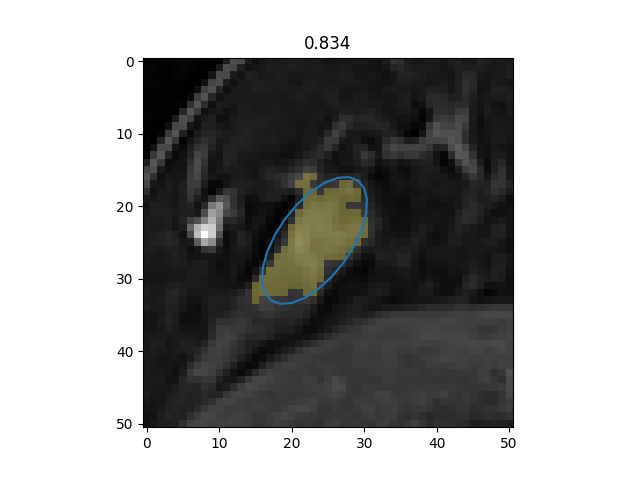

In [117]:
plot_1slice(final_image, final_mask, final_mask_bb, center, k, cont_ellipse, di, di_resized)

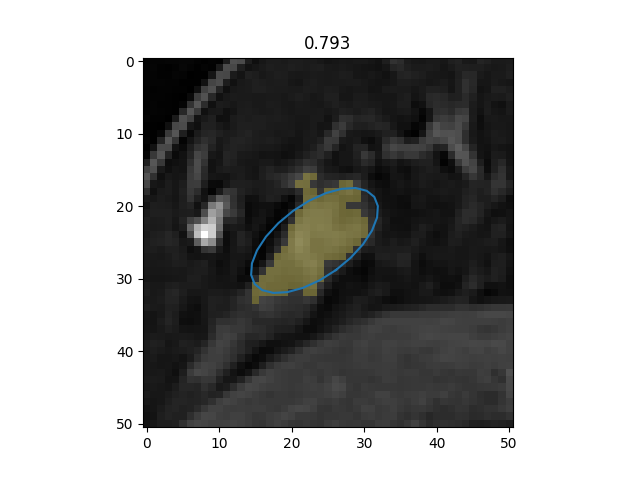

In [118]:
plot_1slice(final_image, final_mask, final_mask_bb, center_MCD, k, cont_ellipse_MCD, di_MCD, di_resized)

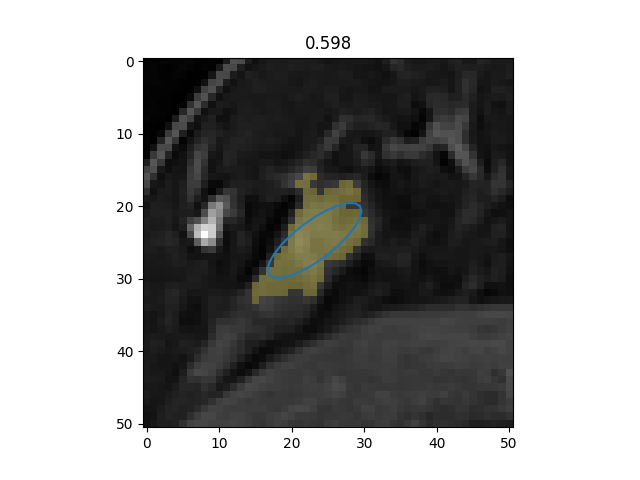

In [119]:
plot_1slice(final_image, final_mask, final_mask_bb, center_rpca, k, cont_ellipse_rpca, di_rpca, di_resized)

In [63]:
a_ma_bb[91,207:215,85:95]

array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [52]:
np.where(a_ma_bb==1)

(array([ 91,  91,  91, ..., 111, 111, 111]),
 array([206, 206, 206, ..., 224, 224, 224]),
 array([ 88,  89,  90, ..., 107, 108, 109]))

In [67]:
final_mask_bb[100]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

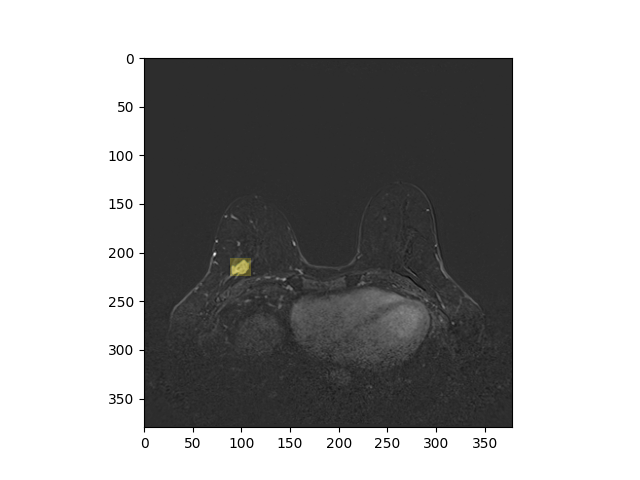

In [68]:
plt.close('all')
plt.imshow(final_image[100], cmap='Greys_r')
plt.imshow(final_mask[100], alpha=0.25*(final_mask[100]>0))
plt.imshow(final_mask_bb[100], alpha=0.25*(final_mask_bb[100]>0))